In [1]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import matplotlib.pyplot as plt
import requests

In [2]:
"""COCO Class labeles"""
class_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


MODEL_REPO = "facebookresearch/detr:main" # The model repo from pytorch hub
MODEL_NAME = "detr_resnet50"

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
""" Samples
cats and dogs:
    https://images.unsplash.com/photo-1543107484-b13a21b26e8c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8NHx8aGVyZHxlbnwwfDB8MHx8&w=1000&q=80
images of 10 cars:
    https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
image of many elephents:
    https://i.ytimg.com/vi/vrlX3cwr3ww/maxresdefault.jpg
"""
url = input()

    https://images.unsplash.com/photo-1543107484-b13a21b26e8c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8NHx8aGVyZHxlbnwwfDB8MHx8&w=1000&q=80


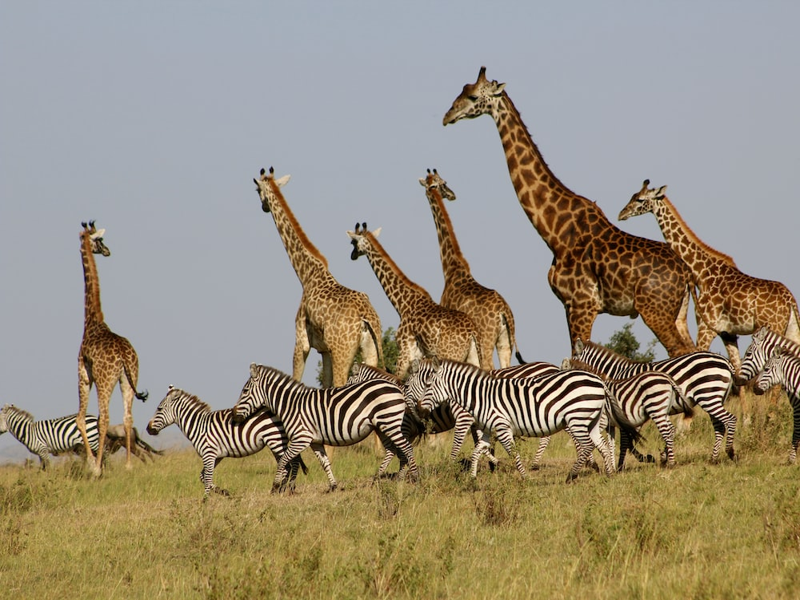

In [4]:
img = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
img_size = img.size
img

In [5]:
def box_cxcywh_to_xyxy(x):
    """
    Converting the bounding boxes from DETR format to xy coordiante pairs
    """
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
        (x_c + 0.5 * w), (y_c + 0.5 * h)]

    return torch.stack(b, dim=1)


In [6]:
def rescale_boxes(out_bbox, size, device='cuda:0'):
    """
    Rescaling the generated bounding boxes within [0, 1] to the original image height and width.
    """
    img_w, img_h = size
    device_tensor = torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32, device=device)

    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * device_tensor

    return b

In [7]:
model = torch.hub.load(MODEL_REPO, MODEL_NAME, pretrained=True)
model = model.cuda()

img_tensor = transform(img).unsqueeze(0).cuda()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache

In [8]:
model = model.eval()
with torch.no_grad():
  output = model(img_tensor)

In [9]:
probs = output["pred_logits"].softmax(-1)[0, :, :-1] # returns bounding boxes and labels
keep = probs.max(-1).values > 0.95 # only predictions with 0.95 probability or higher

bboxes_scaled = rescale_boxes(output['pred_boxes'][0, keep], img_size)

In [10]:
labels = [class_labels[i] for i in probs[keep].argmax(1)]
print(labels)

['zebra', 'zebra', 'zebra', 'zebra', 'giraffe', 'zebra', 'giraffe', 'giraffe', 'giraffe', 'giraffe', 'zebra', 'giraffe']


In [11]:
""" `torchvision.utils.draw_bounding_boxes` requires images in the following format"""
img_bb = torch.tensor((T.ToTensor()(img) * 255), dtype=torch.uint8)
annotated_img = draw_bounding_boxes(img_bb, boxes=bboxes_scaled, labels=labels, width=2)

<ipython-input-11-bf07ee8e9c6d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_bb = torch.tensor((T.ToTensor()(img) * 255), dtype=torch.uint8)


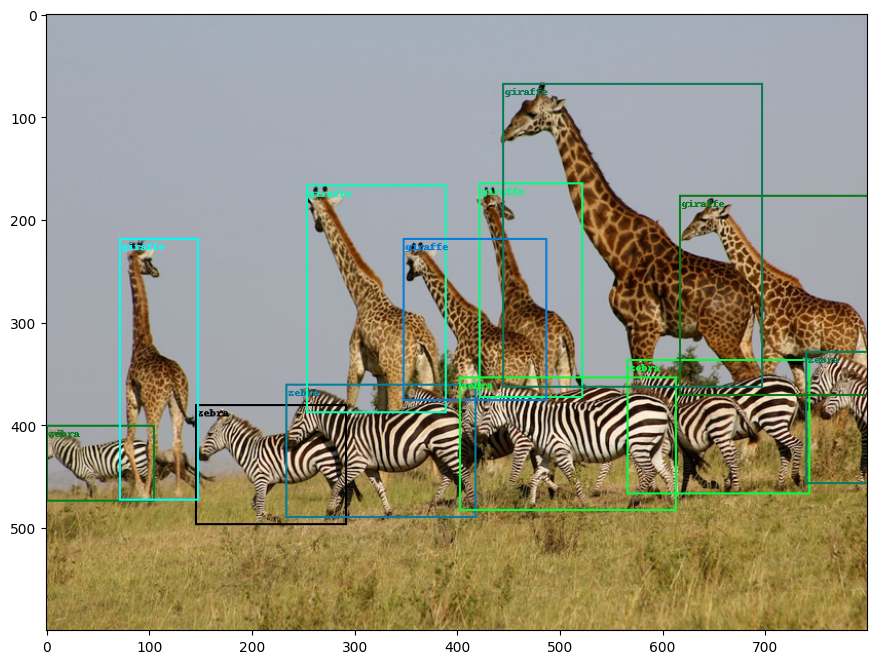

In [12]:
fig = plt.figure(figsize=(14, 8))
plt.imshow(annotated_img.permute(1, 2, 0))